<a href="https://colab.research.google.com/github/AlexTsev/DeepLearning/blob/master/librosa_AudioEmotionAnalysis_Ravdess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyAudioAnalysis
!pip install pydub
!pip install eyed3

In [2]:
import librosa
from librosa import display
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import glob
import time
import joblib
from pyAudioAnalysis import ShortTermFeatures as aFs

In [3]:
from google.colab import files
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


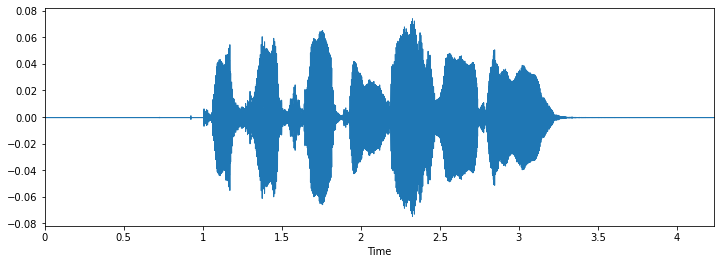

Streaming output truncated to the last 5000 lines.
       -8.39790917e-02,  1.30140674e+00, -6.00411805e-01,  1.38929995e+00,
        2.66244450e+00,  4.63236099e+00,  4.96943434e+00,  2.89021526e+00,
        4.39573994e+00,  2.82294297e+00,  3.29730405e+00,  2.15026917e+00]), array([-536.27165851,   50.35135768,  -27.31987752,   11.50908898,
         -3.42691201,   -3.65145982,   -6.28467807,  -13.71510484,
         -7.73876274,   -0.64055908,  -11.20309367,   -4.44344643,
         -5.58276592,    2.52412807,   -1.8122186 ,    2.06999491,
         -5.92486551,    4.85601708,    5.46141545,   10.03785026,
          5.44361686,    6.76428957,    5.60609171,    9.8142635 ,
          5.74326109,    4.9301272 ,    1.15360608,    2.88409454,
          4.45689023,    3.71551219,    2.12429662,    2.47839531,
          2.64447257,    4.61895274,    4.3851512 ,    4.39183508,
          3.2017944 ,    1.53618362,    1.23244084,    2.1119779 ]), array([-6.90246988e+02,  7.95697657e+01,  4.134585

In [10]:

sample_path = '/gdrive/My Drive/datasets/ravdess_dataset/RAVDESS_Music/Actor_01/03-02-01-01-01-01-01.wav'
signal, sampling_rate = librosa.load(sample_path)

plt.figure(figsize=(12, 4))
librosa.display.waveplot(signal, sr=sampling_rate)
plt.show()


#path = 'RAVDESS/Ravdess_Music'
path = "/gdrive/My Drive/datasets/ravdess_dataset/RAVDESS_Music"
path2 = "/gdrive/My Drive/datasets/ravdess_dataset/RAVDESS_Speech"
data = []

start_time = time.time()

for subdir, dirs, files in os.walk(path):
  for file in files:
      try:
        print('file:', file)
        #Load librosa array, obtain mfcss, store the file and the mcss information in a new array
        X, sample_rate = librosa.load(os.path.join(subdir, file), res_type='kaiser_fast')
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
        file = int(file[7:8]) - 1
        arr = mfccs, file
        #print(arr)
        data.append(arr)
      # If the file is not valid, skip it
      except ValueError:
        continue

print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

# Creating X and y: zip makes a list of all the first elements, and a list of all the second elements.
X, y = zip(*data)
print('x:',X,'y:',y)

X = np.asarray(X)
y = np.asarray(y)
print(X.shape, y.shape)


# **USE JOBLIB TO SKIP THE LOADING PART**

In [22]:
# Saving joblib files to not load them again with the loop above

x_name = 'x_music_librosa.joblib'
y_name = 'y_music_librosa.joblib'
save_dir = '/gdrive/My Drive/joblib_features/ravdess/'

savedX = joblib.dump(X, os.path.join(save_dir, x_name))
savedy = joblib.dump(y, os.path.join(save_dir, y_name))

# **Music**

In [23]:
# Loading saved models
X = joblib.load('/gdrive/My Drive/joblib_features/ravdess/x_music_librosa.joblib')
y = joblib.load('/gdrive/My Drive/joblib_features/ravdess/y_music_librosa.joblib')
##################

In [24]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix
#from sklearn.tree import convert_to_graphviz

from io import StringIO
import IPython
from IPython.display import Image
import pydotplus
from sklearn.tree import export_graphviz
import graphviz

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#DTree
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

predictions = dtree.predict(X_test)
print('X_test:',predictions)
dot_data = StringIO()

print(classification_report(y_test, predictions))

class_labels = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful']
features = ['MFCC_01','MFCC_02','MFCC_03','MFCC_04','MFCC_05','MFCC_06','MFCC_07','MFCC_08','MFCC_09','MFCC_10','MFCC_11','MFCC_12','MFCC_13','MFCC_14','MFCC_15','MFCC_16','MFCC_17','MFCC_18','MFCC_19','MFCC_20','MFCC_21','MFCC_22','MFCC_23','MFCC_24','MFCC_25','MFCC_26','MFCC_27','MFCC_28','MFCC_29','MFCC_30','MFCC_31','MFCC_32','MFCC_33','MFCC_34','MFCC_35','MFCC_36','MFCC_37','MFCC_38','MFCC_39','MFCC_40']

#convert_to_graphviz(dtree)
#export_graphviz(dtree, out_file=dot_data, filled=True, special_characters=True,
                #rounded=True, feature_names=features, class_names=class_labels)
export_graphviz(dtree, out_file="/gdrive/My Drive/joblib_features/ravdess/mytree.dot")
with open("/gdrive/My Drive/joblib_features/ravdess/mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
#graph.set_size('0.7')
#Image(graph.create_png())

#RForest
rforest = RandomForestClassifier(criterion="gini", max_depth=10, max_features="log2",
                                 max_leaf_nodes = 100, min_samples_leaf = 3, min_samples_split = 20,
                                 n_estimators= 22000, random_state= 12)

rforest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='log2', max_leaf_nodes=100,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=22000,
                       n_jobs=None, oob_score=False, random_state=12, verbose=0,
                       warm_start=False)

predictions = rforest.predict(X_test)

print(classification_report(y_test, predictions))

x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

print(x_traincnn.shape, x_testcnn.shape)

X_test: [5 3 3 0 3 3 1 0 4 3 4 5 4 1 4 5 4 3 1 2 0 2 5 3 3 5 4 4 5 1 4 4 1 2 4 4 5
 5 5 1 1 1 3 1 4 4 0 0 2 1 0 0 1 1 2 3 0 2 3 5 4 3 2 4 4 1 1 5 3 2 1 5 3 5
 2 0 3 4 5 2 0 1 2 5 3 5 0 2 3 5 0 5 5 1 5 1 0 0 1 3 0 0 4 0 2 4 4 1 1 3 5
 2 2 4 1 5 5 4 5 3 2 5 2 5 4 2 2 3 0 3 4 1 0 5 4 4 1 4 1 5 2 1 3 1 5 0 2 0
 3 4 2 5 1 2 1 5 1 5 2 3 5 4 3 1 5 4 3 3 0 2 1 5 2 1 0 2 1 0 5 4 5 4 3 3 5
 3 3 3 4 1 4 2 4 0 4 4 4 0 1 3 0 4 0]
              precision    recall  f1-score   support

           0       0.61      0.74      0.67        23
           1       0.83      0.77      0.80        39
           2       0.64      0.75      0.69        24
           3       0.68      0.52      0.59        44
           4       0.74      0.74      0.74        39
           5       0.53      0.59      0.56        34

    accuracy                           0.67       203
   macro avg       0.67      0.69      0.67       203
weighted avg       0.68      0.67      0.67       203


^
Expected {'graph' | 'digraph'}  (

In [25]:
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
import tensorflow.keras
from tensorflow.keras import utils
#import keras
#from keras.utils import np_utils
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv1D, MaxPool1D, MaxPooling1D
from tensorflow.keras.optimizers import SGD,RMSprop,Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.metrics
import tensorflow.keras.callbacks  as callbacks
from tensorflow.keras.callbacks import EarlyStopping


model = Sequential()

model.add(Conv1D(58, 5, activation='relu', padding='same', input_shape=(40, 1)))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5, activation='relu', padding='same'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(6))
model.add(Activation('softmax'))

opt = 'Adam'
#opt = tensorflow.keras.optimizers.RMSprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)
model.summary()

model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

cnnhistory = model.fit(x_traincnn, y_train, batch_size=64, epochs=1000, validation_data=(x_testcnn, y_test))



# 0 = neutral, 1 = calm, 2 = happy, 3 = sad, 4 = angry, 5 = fearful

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 40, 58)            348       
_________________________________________________________________
dropout_12 (Dropout)         (None, 40, 58)            0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 5, 58)             0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 5, 128)            37248     
_________________________________________________________________
dropout_13 (Dropout)         (None, 5, 128)            0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 640)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                

# **PLOTS - CONFUSION MATRIX**

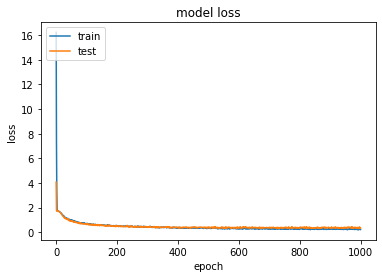

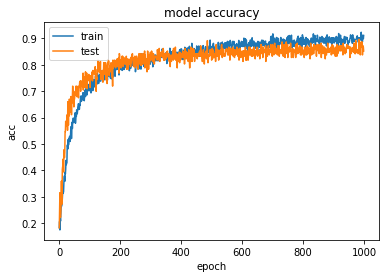

[2 2 3 0 3 3 1 0 3 3 2 5 2 1 4 5 4 3 3 2 0 4 5 3 3 4 4 4 5 1 4 5 1 2 4 2 5
 5 5 3 3 1 3 3 3 0 0 0 2 1 0 1 1 1 4 3 0 2 3 3 4 5 1 4 4 1 1 2 3 5 1 5 3 5
 2 4 2 4 5 1 0 1 2 5 3 5 0 0 4 5 3 3 0 0 4 1 1 5 1 3 0 0 4 0 5 4 4 1 1 3 3
 2 2 4 1 5 4 4 5 3 2 5 2 5 3 5 3 3 3 1 4 1 3 3 4 0 1 5 1 3 4 2 5 1 3 0 2 3
 3 4 1 3 1 2 1 3 1 3 2 3 5 4 1 1 3 4 3 3 5 2 1 5 2 1 3 1 1 0 5 5 5 5 5 5 3
 0 3 1 4 3 2 2 4 0 2 3 4 0 1 5 0 2 3]
[2 2 5 0 3 3 1 0 4 3 2 5 4 1 4 5 4 3 3 2 0 4 5 3 3 4 4 4 3 1 4 5 1 2 4 4 4
 4 5 3 3 1 3 3 4 0 0 0 2 1 0 1 1 1 2 3 0 1 3 3 4 5 1 4 4 1 1 2 3 2 1 5 3 5
 2 4 3 4 5 1 0 1 2 3 3 5 0 0 4 4 3 5 0 0 5 1 1 5 1 3 0 0 4 0 5 4 4 1 1 3 5
 2 2 4 1 5 4 4 5 3 2 5 2 4 3 2 5 3 3 1 4 1 3 5 4 0 1 4 1 3 5 1 5 1 3 0 2 3
 3 4 1 3 1 2 1 3 1 3 2 3 5 4 3 1 5 4 3 3 5 2 1 3 2 1 3 1 1 0 5 5 5 5 5 5 5
 0 3 1 4 3 2 2 4 0 2 3 4 0 1 5 0 4 4]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       0.97      0.95      0.96        39
           

In [26]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

predictions = model.predict_classes(x_testcnn)
print(predictions)

#print(y_test)

new_Ytest = y_test.astype(int)
print(new_Ytest)

#Okay, now we can display the classification report:

from sklearn.metrics import classification_report
report = classification_report(new_Ytest, predictions)
print(report)

from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(new_Ytest, predictions)
print (matrix)

# **Speech**

In [27]:
# Loading saved models
X = joblib.load('/gdrive/My Drive/joblib_features/ravdess/x_speech_librosa.joblib')
y = joblib.load('/gdrive/My Drive/joblib_features/ravdess/y_speech_librosa.joblib')
##################

In [28]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix
#from sklearn.tree import convert_to_graphviz

from io import StringIO
import IPython
from IPython.display import Image
import pydotplus
from sklearn.tree import export_graphviz
import graphviz

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#DTree
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

predictions = dtree.predict(X_test)
print('X_test:',predictions)
dot_data = StringIO()

print(classification_report(y_test, predictions))

class_labels = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
features = ['MFCC_01','MFCC_02','MFCC_03','MFCC_04','MFCC_05','MFCC_06','MFCC_07','MFCC_08','MFCC_09','MFCC_10','MFCC_11','MFCC_12','MFCC_13','MFCC_14','MFCC_15','MFCC_16','MFCC_17','MFCC_18','MFCC_19','MFCC_20','MFCC_21','MFCC_22','MFCC_23','MFCC_24','MFCC_25','MFCC_26','MFCC_27','MFCC_28','MFCC_29','MFCC_30','MFCC_31','MFCC_32','MFCC_33','MFCC_34','MFCC_35','MFCC_36','MFCC_37','MFCC_38','MFCC_39','MFCC_40']

#convert_to_graphviz(dtree)
#export_graphviz(dtree, out_file=dot_data, filled=True, special_characters=True,
                #rounded=True, feature_names=features, class_names=class_labels)
export_graphviz(dtree, out_file="/gdrive/My Drive/joblib_features/ravdess/mytree.dot")
with open("/gdrive/My Drive/joblib_features/ravdess/mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
#graph.set_size('0.7')
#Image(graph.create_png())

#RForest
rforest = RandomForestClassifier(criterion="gini", max_depth=10, max_features="log2",
                                 max_leaf_nodes = 100, min_samples_leaf = 3, min_samples_split = 20,
                                 n_estimators= 22000, random_state= 12)

rforest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='log2', max_leaf_nodes=100,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=22000,
                       n_jobs=None, oob_score=False, random_state=12, verbose=0,
                       warm_start=False)

predictions = rforest.predict(X_test)

print(classification_report(y_test, predictions))

x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

print(x_traincnn.shape, x_testcnn.shape)

X_test: [7 6 1 2 5 1 6 6 4 1 6 4 7 1 3 3 4 5 1 5 7 7 1 7 3 3 2 7 5 2 7 2 1 3 5 1 5
 4 6 4 4 7 3 4 5 0 5 0 4 6 7 7 7 4 0 1 6 7 2 0 3 6 7 2 7 7 4 6 3 6 1 7 1 4
 3 0 4 6 6 7 6 7 3 1 5 5 5 1 2 1 3 7 5 5 1 4 7 6 3 4 2 2 1 6 7 4 6 3 6 0 7
 0 6 1 0 4 7 7 5 6 2 2 7 6 2 6 2 4 2 3 1 5 7 1 1 1 1 1 7 3 6 3 2 2 2 4 2 3
 7 4 4 6 1 5 4 0 2 2 3 4 4 4 4 3 3 7 3 1 5 2 3 5 5 7 2 2 4 2 1 5 0 5 1 7 3
 1 7 3 5 7 1 3 5 1 0 7 4 6 6 1 5 2 2 4 1 7 6 1 1 6 3 1 6 3 1 0 1 2 6 2 3 7
 5 5 5 3 6 6 2 0 2 6 0 2 5 6 3 7 3 1 4 1 7 1 7 1 1 0 4 3 5 6 4 7 5 2 2 2 2
 4 3 1 6 3 6 4 4 3 5 1 2 2 3 7 1 7 4 3 6 4 6 0 2 5 6 3 1 5]
              precision    recall  f1-score   support

           0       0.25      0.22      0.24        18
           1       0.61      0.62      0.62        45
           2       0.24      0.24      0.24        38
           3       0.24      0.25      0.24        36
           4       0.42      0.41      0.41        37
           5       0.39      0.36      0.38        36
           6       0.23     

In [29]:
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
import tensorflow.keras
from tensorflow.keras import utils
#import keras
#from keras.utils import np_utils
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv1D, MaxPool1D, MaxPooling1D
from tensorflow.keras.optimizers import SGD,RMSprop,Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.metrics
import tensorflow.keras.callbacks  as callbacks
from tensorflow.keras.callbacks import EarlyStopping


model = Sequential()

model.add(Conv1D(58, 5, activation='relu', padding='same', input_shape=(40, 1)))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5, activation='relu', padding='same'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(8))
model.add(Activation('softmax'))

opt = 'Adam'
#opt = tensorflow.keras.optimizers.RMSprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)
model.summary()

model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

cnnhistory = model.fit(x_traincnn, y_train, batch_size=64, epochs=1000, validation_data=(x_testcnn, y_test))



# 0 = neutral, 1 = calm, 2 = happy, 3 = sad, 4 = angry, 5 = fearful, 6 = disgust, 7 = surprised

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_14 (Conv1D)           (None, 40, 58)            348       
_________________________________________________________________
dropout_14 (Dropout)         (None, 40, 58)            0         
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 5, 58)             0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 5, 128)            37248     
_________________________________________________________________
dropout_15 (Dropout)         (None, 5, 128)            0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 640)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 8)                

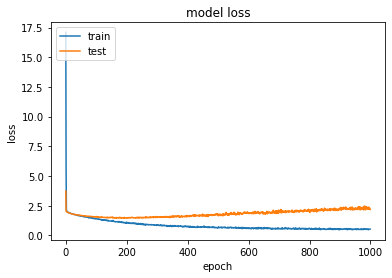

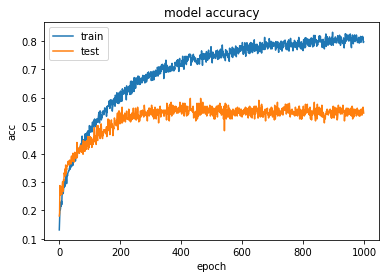

[6 1 3 1 4 3 2 3 5 0 3 7 7 6 6 6 2 1 1 2 7 2 1 3 2 6 7 7 6 6 7 7 1 6 6 0 5
 4 0 4 2 0 3 4 5 7 1 6 4 4 7 7 5 4 1 0 4 7 2 1 7 6 5 4 3 7 2 6 5 2 1 7 1 2
 6 1 2 7 3 7 3 2 6 1 2 4 3 0 0 4 1 0 2 5 6 6 7 5 1 6 3 7 1 5 2 2 3 6 6 1 7
 2 7 5 6 5 7 2 5 6 6 2 3 6 3 5 7 7 6 3 1 4 5 1 3 7 0 2 0 3 1 5 2 3 2 5 4 0
 7 4 3 0 6 6 2 3 7 7 5 6 7 4 4 0 1 2 5 1 5 7 2 2 6 6 5 2 2 7 1 5 1 6 1 3 0
 1 7 5 5 7 6 6 4 1 0 5 6 6 6 1 5 2 6 7 3 7 6 1 1 1 3 3 3 7 1 6 6 2 6 7 3 6
 5 4 3 7 1 3 2 2 5 7 2 7 7 4 6 7 4 1 3 1 6 1 5 1 1 1 2 4 3 2 4 2 5 5 5 7 7
 0 7 3 1 1 4 0 4 2 4 1 3 7 1 4 5 6 2 1 6 5 6 5 5 5 3 6 1 2]
[6 1 1 1 4 0 2 5 7 0 6 7 4 6 2 6 4 5 1 5 7 0 0 3 5 3 7 7 6 5 7 4 1 4 7 0 5
 4 4 4 2 1 1 4 5 3 1 0 4 4 3 7 7 4 1 1 1 7 2 1 7 6 7 7 5 2 2 6 7 2 1 7 1 2
 6 1 4 7 3 7 3 3 6 1 2 4 5 0 2 1 0 0 4 5 0 5 7 1 3 6 5 6 5 5 2 7 3 6 6 1 7
 5 7 1 6 5 5 6 5 6 7 2 7 6 3 5 7 2 6 6 1 2 2 5 3 2 1 2 5 4 5 3 2 3 4 2 4 0
 7 4 6 3 1 4 2 0 5 3 7 5 4 4 4 3 3 2 5 1 2 7 2 5 5 6 5 2 4 7 1 2 1 6 1 3 0
 1 7 5 5 4 6 6 3 1 3 5 6 6 6 1 5 2 6 2 1

In [30]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

predictions = model.predict_classes(x_testcnn)
print(predictions)

#print(y_test)

new_Ytest = y_test.astype(int)
print(new_Ytest)

#Okay, now we can display the classification report:

from sklearn.metrics import classification_report
report = classification_report(new_Ytest, predictions)
print(report)

from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(new_Ytest, predictions)
print (matrix)